In [1]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm import tqdm

root_dir = "../"
sys.path.append(root_dir)

from dataset import BooleanDataset
from model import BooleanF
from shaplit import shaplit

figure_dir = os.path.join(root_dir, "figures", "boolean")
os.makedirs(figure_dir, exist_ok=True)

torch.set_grad_enabled(False)

sns.set_theme()
sns.set_context("paper", font_scale=1.8)

In [2]:
# `m` is the number of samples
# `k` is the number of components in each sample
# `n` is the number of features in each component
m = int(1e03)
k = 2
n = 5
# `t` is the threshold
t = 3
# `N` is the set of features `N = {0, 1, ..., (k*n)-1}`
N = set(range(k * n))

# initialize the dataset
dataset = BooleanDataset(m, k, n)
# initialize the ground-truth Boolean function
model = BooleanF(n, t)

# find positive samples
X = dataset.data
Y = model(X)

P_idx = Y.nonzero()

In [3]:
# `K` is the number of null statistics to compute
# `M` is the number of reference samples to draw
K = int(100000)
M = 1

# `x` is the first positive sample in the dataset
idx = 0
x = X[P_idx[idx]]
y = Y[P_idx[idx]]

# for a feature `j` and a set of features `C \in [n] \setminus \{j\}`,
# `P` contains the p-value of the SHAPLIT procedure
# `B` contains the upper bound `1 - \gamma_{j,C}`
P = np.empty((2 ** ((k * n) - 1),))
B = np.empty_like(P)
# for each feature in `x`
for j, xj in enumerate(x[0]):
    # only consider important features,
    # i.e. features above the threshold
    if np.abs(xj) < t:
        continue

    # `S` is the set of features in `x` that are not `j`
    # `q` is a counter for the number of tests performed
    S = N - {j}
    q = 0

    # for each subset `C` of `S`
    for c in range(len(S) + 1):
        CC = combinations(S, c)
        for C in CC:
            C = set(C)

            # estimate the summand `\gamma_{j,C}` in the
            # Shapley value of feature `j`
            C.add(j)
            f = model(dataset.cond(x, C, K))

            C.remove(j)
            f_null = model(dataset.cond(x, C, K))

            g = (f - f_null).mean().item()

            # compute the p-value of the SHAPLIT procedure
            p = shaplit(model, dataset.cond, x, j, C, K=K, M=M).item()

            B[q] = 1 - g
            P[q] = p
            q += 1
    break

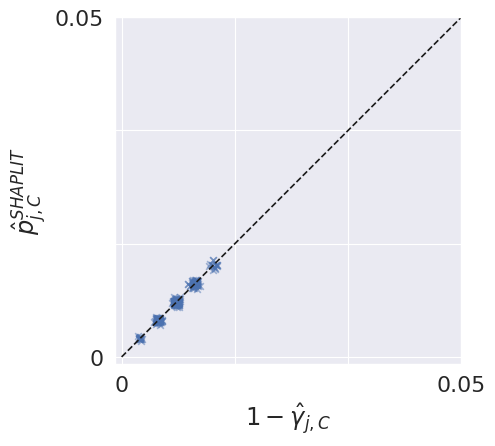

In [4]:
# code to reproduce Fig. 1.a
_, ax = plt.subplots(figsize=(16 / 2, 9 / 2))
ax.scatter(B, P, marker="x", alpha=0.5)
ax.plot([0, 1], [0, 1], "k--", label="bound")
ax.set_xlabel(r"$1 - \hat{\gamma}_{j,C}$")
ax.set_ylabel(r"$\hat{p}^{SHAPLIT}_{j,C}$")
ax.set_xlim(-0.001, 0.05)
ax.set_ylim(-0.001, 0.05)
ax.set_xticks([0, 0.05 / 3, 2 * 0.05 / 3, 0.05])
ax.set_yticks([0, 0.05 / 3, 2 * 0.05 / 3, 0.05])
ax.set_xticklabels([0, None, None, 0.05])
ax.set_yticklabels([0, None, None, 0.05])
ax.set_aspect("equal")
plt.savefig(os.path.join(figure_dir, "bound.pdf"), bbox_inches="tight")
plt.show()

In [5]:
# `K` is the number of null statistics to compute
# `l` is the number of positive features to aggregate over
K = 1000
l = 20

# for a feature `j` and a set of features `C \in [n] \setminus \{j\}`,
# `P` contains the p-value of the SHAPLIT procedure
# `B` contains the upper bound `1 - \gamma_{j,C}`
# `CDF_P` contain the cumulative distribution function of the p-values
# `CDF_B` contain the cumulative distribution function of the upper bounds
P = np.empty((l, 2 ** ((k * n) - 1)))
B = np.empty_like(P)
CDF_P = np.empty_like(P)
CDF_B = np.empty_like(P)

# `i` is a counter for the number of important features
i = 0
pbar = tqdm(total=l)
# repeat until `l` important features have been aggregated
while i < l:
    x = X[P_idx[i]]
    # for each feature in `x`
    for j, xj in enumerate(x[0]):
        # only consider important features,
        # i.e. features above the threshold
        if xj < t:
            continue

        # `S` is the set of features in `x` that are not `j`
        # `q` is a counter for the number of tests performed
        S = N - {j}
        q = 0

        # for each subset `C` of `S`
        for c in range(len(S) + 1):
            CC = combinations(S, c)
            for C in CC:
                C = set(C)
                C.add(j)

                # estimate the summand `\gamma_{j,C}` in the
                f = model(dataset.cond(x, C, K))

                C.remove(j)
                f_null = model(dataset.cond(x, C, K))

                g = (f - f_null).mean().item()

                # compute the p-value of the SHAPLIT procedure
                p = shaplit(model, dataset.cond, x, j, C, K=K, M=M).item()

                B[i, q] = 1 - g
                P[i, q] = p
                q += 1

        # compute the cumulative distribution function of the p-values
        sort_p_idx = np.argsort(P[i])
        P[i] = P[i][sort_p_idx]
        CDF_P[i] = 1.0 * np.arange(len(P[i])) / len(P[i] - 1)

        # compute the cumulative distribution function of the upper bounds
        sort_b_idx = np.argsort(B[i])
        B[i] = B[i][sort_b_idx]
        CDF_B[i] = 1.0 * np.arange(len(B[i])) / len(B[i] - 1)

        i += 1
        pbar.update(1)
        if i == l:
            break

100%|██████████| 20/20 [01:32<00:00,  1.11it/s]

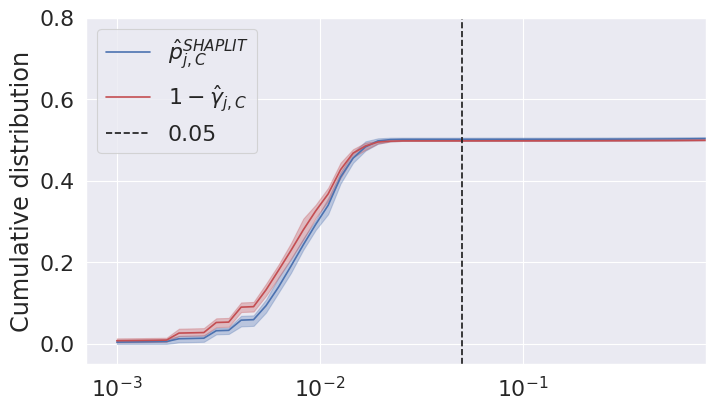

In [6]:
# code to reproduce Fig. 1.b
_, ax = plt.subplots(figsize=(16 / 2, 9 / 2))

uu = 10 ** np.linspace(-3, 0, 50)
interp_CDF_P = np.empty((l, 50))
interp_CDF_B = np.empty_like(interp_CDF_P)
for i in range(l):
    interp_CDF_P[i] = np.interp(uu, P[i], CDF_P[i])
    interp_CDF_B[i] = np.interp(uu, B[i], CDF_B[i])

ax.plot(uu, interp_CDF_P.mean(axis=0), "b-", label=r"$\hat{p}^{SHAPLIT}_{j,C}$")
ax.fill_between(
    uu,
    np.percentile(interp_CDF_P, 5, axis=0),
    np.percentile(interp_CDF_P, 95, axis=0),
    alpha=0.3,
    color="b",
)
ax.plot(uu, interp_CDF_B.mean(axis=0), "r-", label=r"$1 - \hat{\gamma}_{j,C}$")
ax.fill_between(
    uu,
    np.percentile(interp_CDF_B, 5, axis=0),
    np.percentile(interp_CDF_B, 95, axis=0),
    alpha=0.3,
    color="r",
)
ax.set_ylabel("Cumulative distribution")
ax.set_xscale("log")
ax.set_xlim(None, 0.8)
ax.set_ylim(None, 0.8)
ax.axvline(0.05, c="k", linestyle="--", label="0.05")
ax.legend()
plt.savefig(os.path.join(figure_dir, "cdf.pdf"), bbox_inches="tight")
plt.show()